<AxesSubplot:>

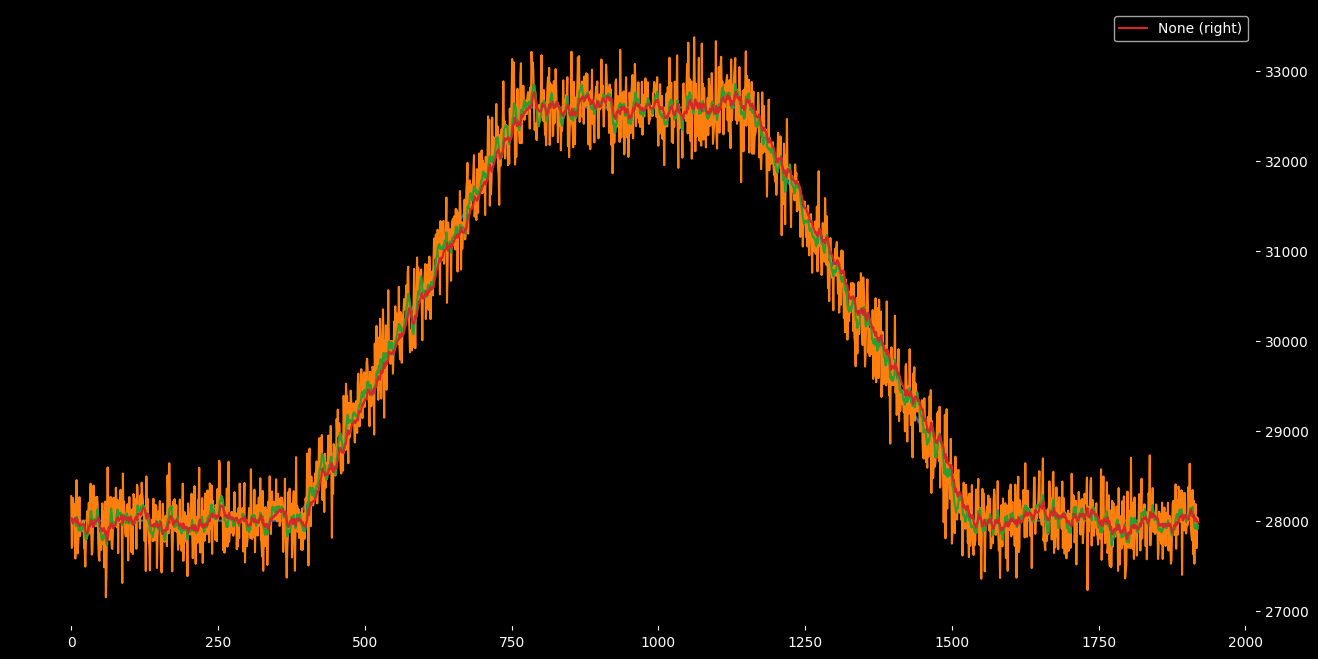

In [188]:
from numpy.random import randn
import pandas as pd
from paper.topic.common_import import *
from filterpy.gh import GHFilter
from paper.systems.rules.mac import mac, ewmac
from systems.provided.rules.breakout import breakout
from sysquant.estimators.vol import simple_vol_calc
initial_price = 28000
noise_facror0 = initial_price * 0.005
noise_facror1 = initial_price * 0.01
noise_facror2 = initial_price * 0.02
noise_facror3 = initial_price * 0.04
noise_facror4 = initial_price * 0.08


noise_facror = noise_facror1
dx = 12
T = 24 * 16
T_Changing = 24 * 16

signals = [initial_price] * T
signals +=[signals[-1] + dx * i for i in range(T_Changing)]
signals += [signals[-1]] * T
signals +=[signals[-1] - dx * i for i in range(T_Changing)]
signals += [signals[-1]] * T 
measurements = [s + randn() * noise_facror for s in signals]
signals = pd.Series(signals)
signals.plot(figsize=Immerse_Size, secondary_y=True)
measurements = pd.Series(measurements)
measurements.plot(figsize=Immerse_Size, secondary_y=True)

# simple_vol_calc(measurements.pct_change()).plot(secondary_y=True)


fast_lookback = 8

ma_fast = measurements.rolling(fast_lookback).mean()
ma_fast.plot(figsize=Immerse_Size, legend=True, secondary_y=True)
# ma_slow = measurements.rolling(fast_lookback * 4).mean()
# forecast = ((ma_fast - ma_slow) / noise_facror)
# forecast = (forecast / forecast.abs().mean()).rename('ma')
# forecast.plot(figsize=Immerse_Size, legend=True)

# ma_fast = measurements.ewm(span=fast_lookback).mean()
# ma_slow = measurements.ewm(span=fast_lookback * 4).mean()
# forecast = ((ma_fast - ma_slow) / noise_facror)
# forecast = (forecast / forecast.abs().mean()).rename('ewma')
# forecast.plot(figsize=Immerse_Size, legend=True)

# ma_fast = breakout(measurements, fast_lookback * 2)
# forecast = (ma_fast / ma_fast.abs().mean()).rename('breakout')
# forecast.plot(figsize=Immerse_Size, legend=True)

gh = GHFilter(x=28000, dx=0, dt=1, g=0.1, h=0)
filtered = pd.Series(gh.batch_filter(measurements)[:, 0])
filtered.plot(legend=True, secondary_y=True)
# forecast = forecast / noise_facror
# forecast = (forecast / forecast.abs().mean()).rename('gh')
# forecast.plot(legend=True, secondary_y=True)
# ma_fast = filtered.ewm(span=fast_lookback).mean()
# ma_slow = filtered.ewm(span=fast_lookback * 4).mean()
# forecast = ((ma_fast - ma_slow) / noise_facror)
# forecast = (forecast / forecast.abs().mean()).rename('filtered-ewma')
# forecast.plot(figsize=Immerse_Size, legend=True) 

# # # pss.ewm(span=24 * 3).mean().plot()
# # # pss.rolling(24 * 3).mean().plot()

In [2]:

instrument_code = 'JD'
fast = 10
slow = 4 * fast

price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
forecast = mac(price, fast, slow).rename('forecast')


price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
ewforecast = ewmac(price, fast, slow).rename('ewforecast')

forecast_df = pd.concat([price, forecast, ewforecast], axis=1)
forecast_df = forecast_df.tail(len(forecast_df) - 2 * slow)

from systems.accounts.account_forecast import pandl_for_instrument_forecast

def select(df):
    return df
    # return df[(df.index > '2016-01-01') & (df.index < '2020-01-01')]

account = pandl_for_instrument_forecast(forecast=forecast_df.forecast, price = forecast_df[instrument_code])
ewaccount = pandl_for_instrument_forecast(forecast=forecast_df.ewforecast, price = forecast_df[instrument_code])
print(len(ewaccount))
print(len(account))
print(len(forecast_df[instrument_code]))
print(len(forecast_df.ewforecast))

pl = account.curve().rename('mac')
ewpl = ewaccount.curve().rename('ewmac')
pl_df = pd.concat([forecast_df[instrument_code], pl, ewpl], axis=1)
pl_df = select(pl_df)
ax = pl_df.plot(secondary_y=instrument_code, figsize=(15,6), color=['green', 'yellow', 'pink'])

forecast_df = select(forecast_df)
plt.show()
ax = forecast_df.plot(figsize=(15,6), color=['green', 'yellow', 'pink'], secondary_y=instrument_code)

ImportError: cannot import name 'GHFilter' from 'filterpy' (/opt/homebrew/Caskroom/miniconda/base/envs/trading/lib/python3.8/site-packages/filterpy-1.4.5-py3.8.egg/filterpy/__init__.py)

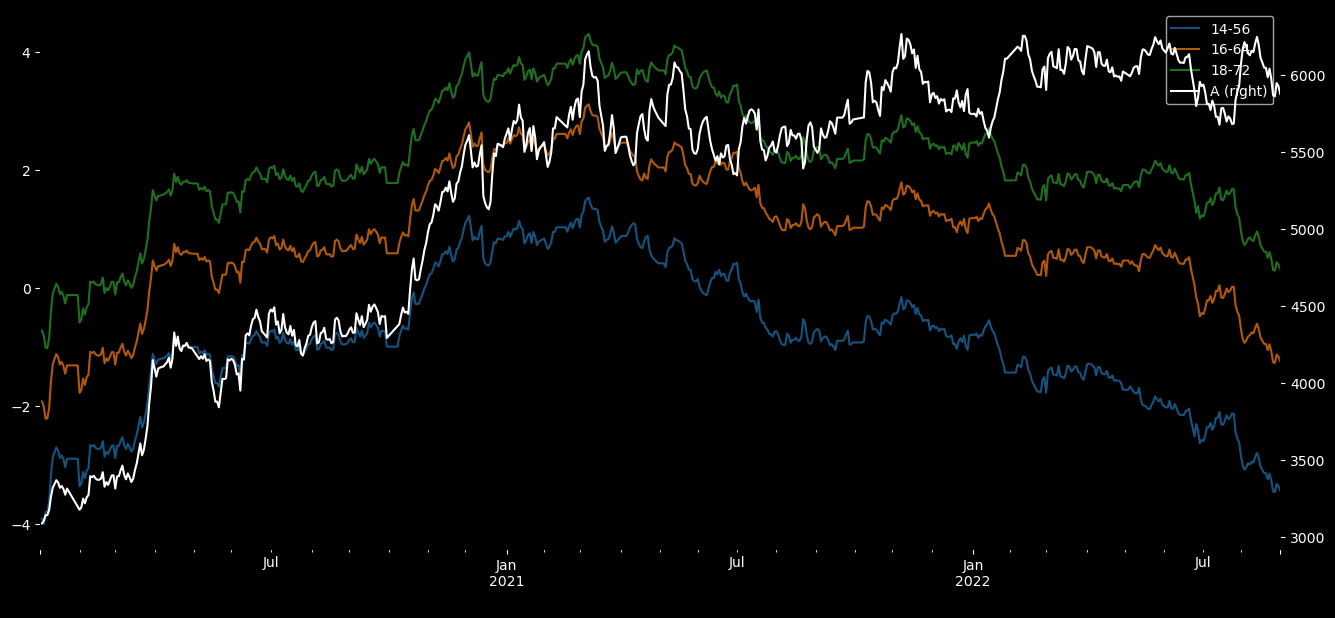

A


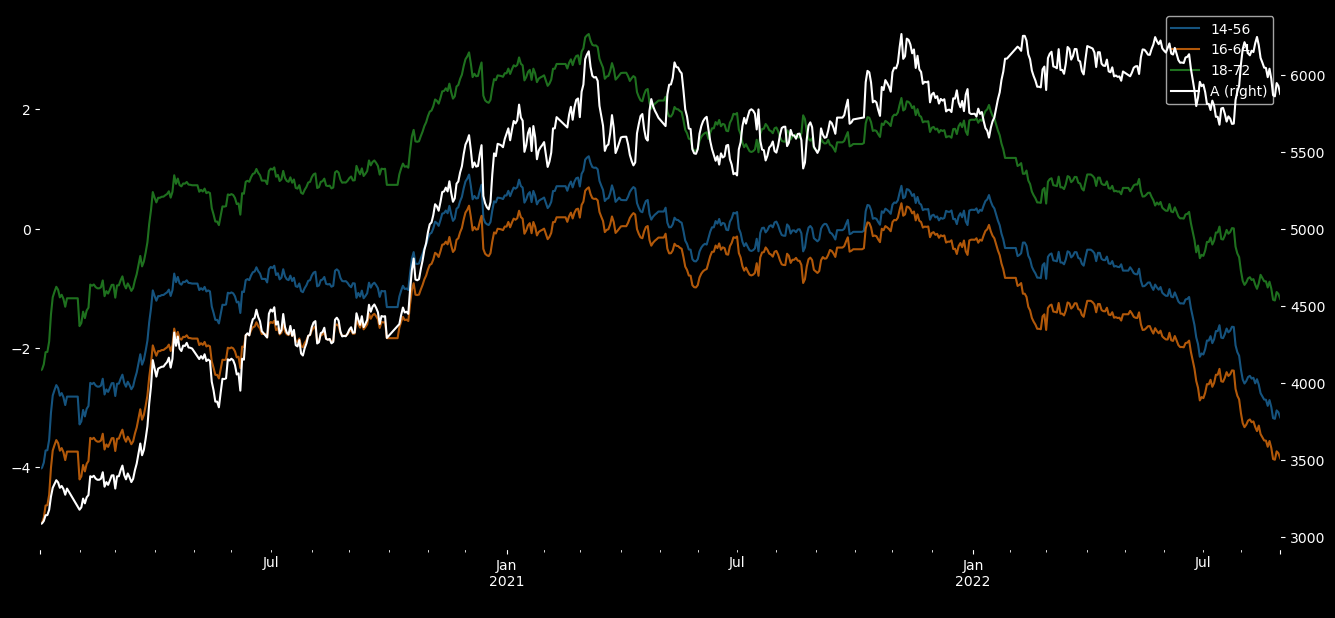

A


In [236]:
from paper.systems.rules.mac import mac
from paper.systems.rules.mac import ewmac
from systems.accounts.account_forecast import pandl_for_instrument_forecast

def select(df):
    # return df
    return df[(df.index > '2020-01-01') & (df.index < '2023-01-01')]

def simulate(instrument_code, filter, fast_range1):
    color_list = list(mcolors.TABLEAU_COLORS.values())
    assert len(color_list) >= len(fast_range1)
    color_list = color_list[:len(fast_range1)]

    pl_df_list = []
    forecast_df_list = []
    for fast in fast_range1:
        slow = 4 * fast

        price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
        forecast = filter(price, fast, slow).rename('forecast{}'.format(slow))
        forecast_df_list.append(forecast)

        price = data.daily_prices(instrument_code).rename(instrument_code).dropna()

        forecast_df = pd.concat([price, forecast], axis=1)
        forecast_df = forecast_df.tail(len(forecast_df) - 2 * slow)

        account = pandl_for_instrument_forecast(forecast=forecast_df['forecast{}'.format(slow)], price = forecast_df[instrument_code])

        pl = account.curve().rename('{}-{}'.format(fast, slow))
        pl_df_list.append(pl)
        
    ax = plt.subplot()
    pl_df_list = pd.concat(pl_df_list, axis=1)
    pl_df_list = select(pl_df_list)
    _ = pl_df_list.plot(secondary_y=instrument_code, ax=ax, figsize=(16,7), color=color_list, alpha=0.7)
    # forecast_df = select(forecast_df[instrument_code])

    price = data.daily_prices(instrument_code).rename(instrument_code).dropna()
    price = select(price)
    price.plot(ax=ax, secondary_y=True, legend=True, color='white')
    plt.show()

    turnover = pd.concat(forecast_df_list, axis=1)
    trades = ((turnover.replace(np.nan, 0).diff() != 0) * 1).sum()
    years = np.abs((turnover.apply(lambda se:se.first_valid_index()) - turnover.last_valid_index()) / pd.Timedelta(365, 'D'))
    avg_hold_days = 12 * 4 * 5 / (trades / years)
    print(instrument_code)
    # display(avg_hold_days)

instrument_code = pd.Series(system.get_instrument_list()).sample(1).iloc[0]
instrument_code = 'A'
# fast_range1 = [2, 3, 4, 5, 6, 7, 8, 9, 18, 22]
fast_range1 = [14, 16, 18]
filter = ewmac
simulate(instrument_code, filter, fast_range1)
simulate(instrument_code, mac, fast_range1)